<a href="https://colab.research.google.com/github/vkamma/nlp_exploration/blob/main/Data_Jobs_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# !pip install gdown
# !pip install yarl
# !pip install texthero
# !pip install wordcloud
# !pip install scattertext

In [6]:
# Download from Google Drive
import gdown

url = "https://drive.google.com/uc?id=1pE7iIWxhjqIQesIBApMvZTJlRqjA8WNN"
output = "data-science-job-search.csv"
gdown.download(url, output, True)
# data-science-job-search.csv

url = "https://drive.google.com/uc?id=1yilShPE4V905GZ96FctJW04wkrZPZgnE"
output = "data-engineer-job-search.csv"
gdown.download(url, output, True)
# data-engineer-job-search.csv

'data-engineer-job-search.csv'

In [7]:
import pandas as pd

data_scientist = pd.read_csv("data-science-job-search.csv")
data_engineer = pd.read_csv("data-engineer-job-search.csv")

In [8]:
data_scientist.describe()

name  ...           title
count             1000  ...            1000
unique             329  ...             329
top     Data Scientist  ...  Data Scientist
freq               235  ...             235

[4 rows x 7 columns]

In [9]:
data_engineer.describe()

name  ...          title
count            1000  ...           1000
unique            428  ...            428
top     Data Engineer  ...  Data Engineer
freq              198  ...            198

[4 rows x 8 columns]

In [10]:
data_scientist

name  ...                                              title
0    Results for "Senior Data Scientist Jobs in Uni...  ...  Results for "Senior Data Scientist Jobs in Uni...
1                                       Data Scientist  ...                                     Data Scientist
2            Data Scientist, New Grad 2019 - Analytics  ...          Data Scientist, New Grad 2019 - Analytics
3    Postdoc Positions in Single Cell Genomics - Da...  ...  Postdoc Positions in Single Cell Genomics - Da...
4                             Principal Data Scientist  ...                           Principal Data Scientist
..                                                 ...  ...                                                ...
995                              Senior Data Scientist  ...                              Senior Data Scientist
996                   Data Scientist/Software Engineer  ...                   Data Scientist/Software Engineer
997      Senior Data Scientist, Online Jobs in Georgia  ...      Senior Data Scientist, Online Jobs in Georgia
998                                 NLP Data Scientist  ...                                 NLP Data Scientist
999                   Data Scientist - Health Outcomes  ...                   Data Scientist - Health Outcomes

[1000 rows x 7 columns]

In [12]:
data_scientist["title"] = ["data scientist"] * len(data_scientist)
data_engineer["title"] = ["data engineer"] * len(data_engineer)

df = pd.concat([data_scientist, data_engineer]).reset_index(drop=True)

In [13]:
df = df[~df.text.isna()]

In [17]:
from yarl import URL

def get_page_source(url: str):
    return URL(url).host
    
df["page_host"] = df["pageUrl"].apply(get_page_source)

In [33]:
import plotly.express as px

top_pages = df["page_host"].value_counts()[:20].to_frame()

fig = px.bar(
    top_pages,
    x=top_pages.index,
    y="page_host",
    labels={"page_host": "frequency", "x": "page host"},
).update_xaxes(
    categoryorder="total descending",
)

fig

In [36]:
import texthero as hero

# Clean text
df["text"] = df["text"].pipe(hero.clean)

# Turn a list of text into a string
text = " ".join(df["text"].values)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
text

'results senior data scientist jobs united states new equian looking hire data scientist join data science team woburn data scientist lead effort improve overpayment accuracy healthcare claims using variety techniques order succeed role must comfortable working others fast paced environment addition need eye detail experience data scientist good understanding natural language processing successful candidate strong work ethic data driven approach must authorized work usa duties responsibilities lead effort determine overpayments contracts sources information automate procedures obtaining reading parsing understanding contracts improve pricing procedures contracts available support initiatives data process quality interface others data science data analytics teams explain insights team members equian employees provide technical expertise aspects claim scoring needed qualifications bachelor\' degree quantitative field strong understanding natural language processing experience python r pr

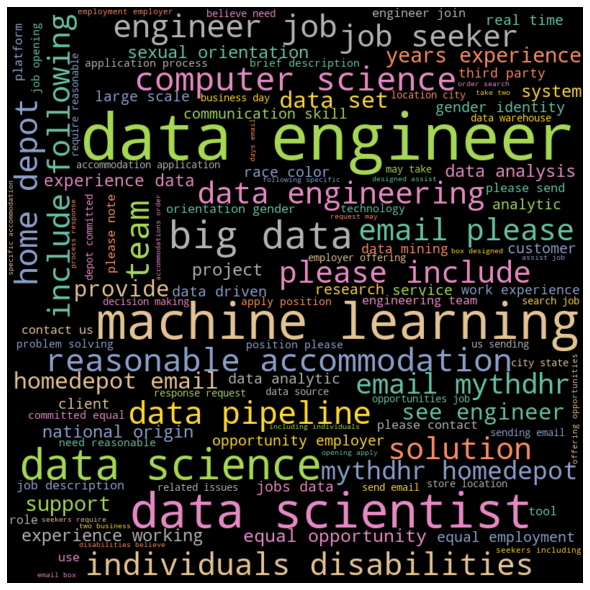

In [46]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

def make_wordcloud(new_text):
    wordcloud = WordCloud(width=800, height=800, min_font_size=10, background_color="black", 
                          colormap="Set2", collocations=True).generate(new_text)
    fig = plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return fig

text_cloud = make_wordcloud(text)

In [49]:
import scattertext as st

analyze_col = "requirements"

# Filter out the rows whose requirement is nan
filtered_df = df[~df[analyze_col].isna()][["title", analyze_col, "page_host"]]

# Tokenize text
filtered_df["parse"] = filtered_df[analyze_col].apply(st.whitespace_nlp_with_sentences)

In [50]:
corpus = (
    st.CorpusFromParsedDocuments(filtered_df, category_col="title", parsed_col="parse")
    .build()
    .get_unigram_corpus()
    .compact(st.AssociationCompactor(2000))
)

In [51]:
import nltk
nltk.download("averaged_perceptron_tagger")

# get DataFrame with terms and their frequency
term_freq_df = corpus.get_term_freq_df()

# Get scaled F-scores of each term in each category
term_freq_df["Data Scientist Score"] = corpus.get_scaled_f_scores("data scientist")
term_freq_df["Data Engineer Score"] = corpus.get_scaled_f_scores("data engineer")

# Remove terms that are not nouns
def is_noun(word: str):
    pos = nltk.pos_tag([word])[0][1]
    return pos[:2] == "NN"

term_freq_df = term_freq_df.loc[map(is_noun, term_freq_df.index)]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [52]:
term_freq_df.sort_values(by="Data Scientist Score", ascending=False).index[:30]

Index(['science', 'analysis', 'machine', 'ability', 'computer', 'work', 's',
       'field', 'r', 'degree', 'statistics', 'quantitative', 'experience',
       'years', 'python', 'data', 'knowledge', 'techniques', 'business',
       'analytics', 'skills', 'bachelor', 'math', 'engineering', 'master',
       'mining', 'development', 'time', 'environment', 'languages'],
      dtype='object', name='term')

In [53]:
term_freq_df.sort_values(by="Data Engineer Score", ascending=False).index[:30]

Index(['self', 'spark', 'design', 'excellent', 'g', 'implement', 'java', 'sql',
       'scala', 'technologies', 'etc', 'e', 'dimensional', 'management',
       'hadoop', 'systems', 'hands', 'sets', 'growth', 'datasets', 'operating',
       'mapreduce', 'aws', 'industry', 'verbal', 'perfect', 'enemy', 'etl',
       'ambiguity', 'awareness'],
      dtype='object', name='term')

In [54]:
html = st.produce_scattertext_explorer(
    corpus,
    category="data scientist",
    category_name="Data scientist",
    not_category_name="Data Engineer",
    minimum_term_frequency=5,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    metadata=corpus.get_df()["page_host"],
    transform=st.Scalers.dense_rank,
)
open("data_science_vs_data_engineer_requirements_terms.html", "w").write(html)

1305469

In [55]:
import IPython
IPython.display.HTML(filename='data_science_vs_data_engineer_requirements_terms.html')